# Log Likelihood Debugging
Getting weird values for log likelihood when we extend p to be 0 and 1 beyond the bins that have persons in them.

In [378]:
# Simulate MCMC model data: pick the true parameter variables from the model's prior distribution.
#import cluster.cntree.cntree as cntree
import logging
import matplotlib.pyplot as plt
import nirt.simulate.simulate_data
import nirt.solver
import numpy as np

%load_ext autoreload
%autoreload 2

for handler in logging.root.handlers[:]: logging.root.removeHandler(handler)
logging.basicConfig(level=logging.INFO, format="%(levelname)-8s %(message)s", datefmt="%a, %d %b %Y %H:%M:%S")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [392]:
np.random.seed(0)

# Number of persons.
P = 1000
# Number of items.
I = 20
# Number of latent ability dimensions (sub-scales).
C = 1
# Using 2-PL model with fixed discrimination and no asymptote for all items.
x, theta, b, c = nirt.simulate.simulate_data.generate_simulated_data(P, I, C, asym=0, discrimination=1)

In [416]:
# Build an IRF from some reasonable theta values.
num_bins = 10
sample_size = 20
theta = nirt.likelihood.initial_guess(x, c)
sample = np.random.choice(np.arange(P, dtype=int), size=sample_size * num_bins, replace=False)
grid = [nirt.grid.Grid(theta[sample, d], num_bins) for d in range(C)]
irf = [nirt.irf.ItemResponseFunction(grid[c[i]], x[:, i]) for i in range(I)]

In [417]:
items = np.where(c == d)[0]
print('d', d, 'items', items)

d 0 items [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


[28 28 15 15 22 20 14 19 24 15]
[0.17857143 0.10714286 0.         0.13333333 0.04545455 0.1
 0.         0.10526316 0.08333333 0.13333333]


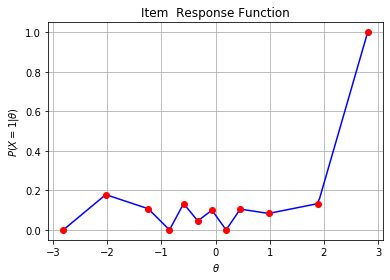

In [418]:
# fig, axs = plt.subplots(len(items) // 4, 4, figsize=(24, 24))
# for k, item in enumerate(items):
#     irf[k].plot(axs[k // 4, k % 4], title="IRF Item {}".format(k))
    
ax = plt.gca()
k = I - 1
irf[k].plot(ax, label="Item {}".format(k))
ax.grid(True)

print(irf[k].count)
print(irf[k].probability)

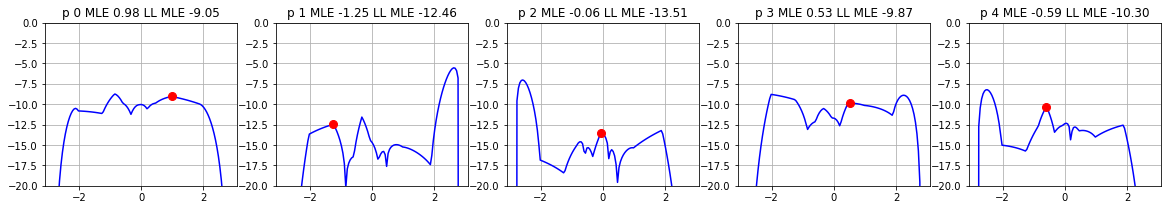

In [437]:
likelihood = nirt.likelihood.Likelihood(x, c, irf)
d = 0

fig, axs = plt.subplots(1, 5, figsize=(20, 3))
for p in range(5):
    i = np.where(c == d)[0][0]
    t = np.linspace(irf[i].x[0], irf[i].x[-1], 10 * len(irf[i].x) + 1)
    active = np.tile([p, d], (len(t), 1))
    likelihood_values = likelihood.log_likelihood_term(t, active=(active[:, 0], active[:, 1]))

    # Verify that we can find the LL maximum with a root finder.
    t_mle = likelihood.parameter_mle(p, d, max_iter=10)
    likelihood_mle = likelihood.log_likelihood_term(t_mle, (np.array([p]), np.array([d])))[0]

    ax = axs[p]
    ax.plot(t, likelihood_values, 'b-')
    ax.grid(True)
    ax.set_ylim([-20, 0])
    ax.plot(np.array([t_mle]), np.array([likelihood_mle]), 'ro', markersize=8)
    ax.set_title("p {} MLE {:.2f} LL MLE {:.2f}".format(p, t_mle, likelihood_mle))